In [1]:
import torch
torch.set_default_dtype(torch.float64)
device = torch.device('cpu')
torch.set_default_device(device)

from torchfem import Solid
from torchfem.materials import IsotropicPlasticity3D
from torchfem.mesh import cube_hexa
from torchfem.sdfs import Sphere, Cylinder, Box, Gyroid, Shell
from torchfem.io import export_mesh
import pyvista
import numpy as np
pyvista.set_plot_theme('document')

c:\Users\bm_tu\Desktop\gnn\gnn_312\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
E = 210e3
nu = 0.3
sigma_y = 250
k = 2e3

def sigma_f(q):
    return sigma_y + k * q
# Derivative of the hardening function
def sigma_f_prime(q):
    return k

material = IsotropicPlasticity3D(E, nu, sigma_f, sigma_f_prime)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

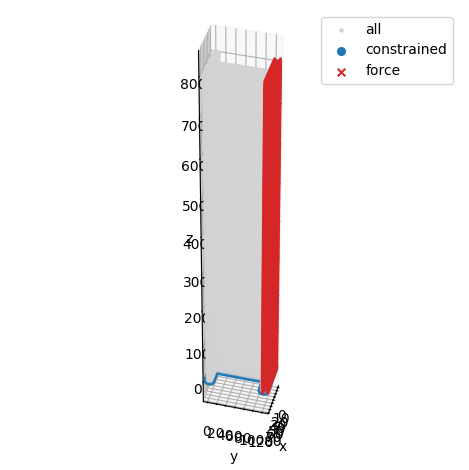

AttributeError: 'Solid' object has no attribute 'K'

In [18]:
model = None
nodes = None
elements = None

idx = 0
torch.random.manual_seed(idx)
np.random.seed(idx)


Lx = np.random.uniform(50,100)      # flange
Ly = np.random.uniform(60,140)      # web
Lz = np.random.uniform(200,1200)    # length
w = np.random.uniform(2,5)          # flange thickness
t = np.random.uniform(1,5)          # web thickness

resolution = torch.randint(1,4,(1,))

## Hollow tube
nodes, elements = cube_hexa(int(Lx/resolution), int((Ly+2*w)/resolution), int(Lz/resolution), Lx, Ly+(2*w), Lz)

# Create a solid object
model = Solid(nodes, elements, material)
center = torch.tensor([Lx/2,(Ly+(2*w))/2,Lz/2])

flange_top = Box(center=center+torch.tensor([0,Ly/2+w/2,0]),size=torch.tensor([Lx,w,Lz]))
flange_bottom = Box(center=center+torch.tensor([0,-Ly/2-w/2,0]),size=torch.tensor([Lx,w,Lz]))
web = Box(center=center+torch.tensor([0,0,0]),size=torch.tensor([t,Ly,Lz]))

body = flange_top|flange_bottom|web
#model.plot(node_property={"SDF": body.sdf(nodes)},contour=("SDF", [0.0]), color="skyblue")

###
sdf_vals = body.sdf(nodes)
inside = sdf_vals <= 2
mask = inside[elements].all(dim=1)
elements = elements[mask]
used = torch.unique(elements)
new_index = -torch.ones(len(nodes), dtype=torch.long)
new_index[used] = torch.arange(len(used))
elements = new_index[elements]
nodes = nodes[used]
model = Solid(nodes, elements, material)
###
model.plot(node_property={"SDF": body.sdf(nodes)})

# Set constraints
#DL = 0.1
eps = 2e-3  # tolerance for floating-point coords
xmin, xmax = nodes[:, 0].min(), nodes[:, 0].max()
ymin, ymax = nodes[:, 1].min(), nodes[:, 1].max()
zmin, zmax = nodes[:, 2].min(), nodes[:, 2].max()
on_z_zero = torch.isclose(nodes[:, 2], zmin, atol=eps)
model.displacements[on_z_zero, :] = 0
model.constraints[on_z_zero, :] = True
#model.constraints[:, 0] = True

n_steps = 100
peak_load = np.random.uniform(1e2,1e4)
on_z_edge = torch.isclose(nodes[:, 1], ymax, atol=eps)

force_vector = torch.zeros_like(nodes)

# Incremental loading
increments = torch.cat((torch.linspace(0.0, 1.0, int(n_steps/2)), torch.linspace(1.0, 0.0, int(n_steps/2))))
bottom = torch.isclose(nodes[:, 1], ymax, atol=eps)
force_vector[on_z_edge, 0] = 0
force_vector[on_z_edge, 1] = -peak_load / on_z_edge.sum()
force_vector[on_z_edge, 2] = 0

#print(on_z_zero.sum(),on_z_edge.sum())
#print(nodes[loc_mask])
#print(nodes[force_mask])

model.forces = force_vector
scaled = force_vector.unsqueeze(0) * increments.view(-1, 1, 1)
scaled_np = scaled.detach().cpu().numpy()
#scaled = np.array([force_vector * inc for inc in increments])

if True:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # all nodes
    ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], s=5, c="lightgray", label="all")
    # constrained
    ax.scatter(nodes[on_z_zero, 0], nodes[on_z_zero, 1], nodes[on_z_zero, 2],
            s=30, c="tab:blue", label="constrained")
    # loaded
    ax.scatter(nodes[on_z_edge, 0], nodes[on_z_edge, 1], nodes[on_z_edge, 2],
            s=30, c="tab:red", marker="x", label="force")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.legend()
    ranges = np.ptp(nodes.T, axis=1)
    ax.set_box_aspect(ranges)
    ax.view_init(elev=40, azim=15)
    plt.tight_layout()
    plt.show()



#u, f, stress, F, state = model.solve(increments=increments,method="spsolve",return_intermediate=True,verbose=True) #rtol=1e-5

torch.save(
    {
        "nodes": model.nodes,
        "stiffness": model.K,
        "u_history": u.detach().cpu(),
        "stress_history":stress.detach().cpu(),
        "deform_grad":F.detach().cpu(),
        "forces":f.detach().cpu(),
        "state":state.detach().cpu(),
        "boundary":model.constraints.detach().cpu(),
        "dirichlet_disp": model.displacements.detach().cpu(),
        "elements":model.elements.detach().cpu(),
        "ext_forces": scaled,
    },
    f"../../torchfem_dataset/simple_beam/sim_{idx}.pt",
)

